In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

# Acceleration Data

Since the accel.csv file is extremely large, I randomly selected 100,000 rows. Then I removed any rows containing infinite and NaN values. Since the original distribution of paitents were approximatly evenly split between patients with Parkinson's and without Parkinson's, I randomly sampled 500 rows of each group.

In [3]:
import random

n = 11980382 #number of records in file (excludes header)
s = 100000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s))

df = pd.read_csv('accel.csv', index_col=0, skiprows=skip)
df.head()

,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,x.PSD.6,x.PSD.10,...,z.mean,z.absolute.deviation,z.standard.deviation,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,time,PK
254,1.066560,40,-0.284883,0.032877,0.041603,0.097576,0.000390,0.000400,0.017195,0.061779,...,9.690441,0.041065,0.049790,0.106403,0.040930,0.047452,0.030301,0.042450,2011-12-21 16:08:53,0
285,1.009638,50,-0.440122,0.030299,0.035772,0.079630,0.169917,0.253842,0.148406,0.044020,...,9.635622,0.056000,0.068117,0.151415,0.087352,0.054855,0.597366,0.342012,2011-12-21 16:09:25,0
299,1.096225,43,-0.751235,0.084701,0.111254,0.307883,0.020181,0.518494,0.484914,0.527556,...,9.508801,0.097918,0.132772,0.359197,0.000014,0.164295,0.862480,1.563894,2011-12-21 16:09:39,0
575,1.018218,48,-0.034528,0.021435,0.024679,0.044334,0.001830,0.046631,0.047705,0.006947,...,9.982556,0.034144,0.041141,0.107260,0.151021,0.242209,0.082224,0.071342,2011-12-21 16:20:48,0
618,1.002498,44,-0.660834,0.218715,0.257771,0.486544,4.678925,8.932974,5.445445,0.173025,...,6.886051,0.201523,0.248683,0.606229,8.137277,9.607136,1.943282,0.251455,2011-12-21 18:39:21,0


In [4]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df_freq_motion_1 = df[df['PK'] == 1].sample(n=500, replace=False)
df_freq_motion_0 = df[df['PK'] == 0].sample(n=500, replace=False)
df = pd.concat([df_freq_motion_1, df_freq_motion_0])
df = df.drop(columns=['time'])
df.head()

,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,x.PSD.6,x.PSD.10,...,y.PSD.10,z.mean,z.absolute.deviation,z.standard.deviation,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,PK
12096044,1.012,35,6.750618,0.111900,0.143288,0.300364,0.296985,1.186820,1.423667,0.346237,...,0.912825,-1.301763,0.213024,0.259378,0.556457,1.507659,4.859704,6.589732,1.981934,1
12215352,1.009,43,4.134529,0.209414,0.264515,0.562856,6.330236,7.891645,6.733434,1.071827,...,0.042477,-8.807511,0.206984,0.237622,0.479386,0.047688,1.353027,3.290413,2.265099,1
2744272,1.000,79,8.633188,0.145035,0.176908,0.388163,0.000305,9.334192,6.018091,2.317132,...,1.241906,-3.492504,0.095851,0.123563,0.447079,1.269823,1.188564,0.877476,1.201407,1
12003709,1.016,34,3.059675,0.073261,0.092699,0.205940,0.245007,0.309767,0.116339,0.067091,...,0.007794,-9.274495,0.032745,0.038960,0.075858,0.011687,0.014748,0.007759,0.018768,1
12252697,1.007,44,1.756505,0.132218,0.148758,0.302892,1.010824,3.266822,1.478573,0.283652,...,0.137819,-9.387861,0.065172,0.078803,0.193235,0.036434,0.208543,0.978749,0.234471,1


# Basic Logistic Regression

Ran a basic logisistic regression model with 5-fold cross validation as a benchmark model.

The data has been standarized such that the mean of each feature is 0 and has a standard deviation of 0. This allows the model weights to be calculated more accurately and faster during gradient descent. This would be helpful when using the larger data.

In [5]:
scaler = StandardScaler()
training_data = df.iloc[:,0:26]
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df['PK'], test_size=0.33, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=10000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7333333333333333

# With Total Acceleration Added In

Since the data had x, y, and z mean, I was interested if adding the total acceleration (calculated by the L2 norm) would serve as a more useful feature for Parkinson's predictor.

In [6]:
def acceleration_simplify(df):
    
    df.columns = df.columns
    
    #Take the mean and divide it by standard deviation
    x_accel_std = df['x.mean']/df['x.standard.deviation']
    y_accel_std = df['y.mean']/df['y.standard.deviation']
    z_accel_std = df['z.mean']/df['z.standard.deviation']
    
    # L2 norm to combine acceleration axis
    total_accel = np.sqrt(np.square(x_accel_std) + np.square(y_accel_std) + np.square(z_accel_std)) 
    new_df = pd.DataFrame(data={'Total_Acceleration': total_accel, 'PK': df['PK']})
    return new_df 

In [7]:
total = acceleration_simplify(df)
total

,Total_Acceleration,PK
12096044,58.037711,1
12215352,41.515314,1
2744272,57.407840,1
12003709,240.415549,1
12252697,124.372846,1
...,...,...
10299930,113.420578,0
189986,145.516453,0
10961248,4.238713,0
1883170,39.425978,0


In [8]:
df2 = pd.concat([total['Total_Acceleration'], df], axis=1)
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()
df2.head()

,Total_Acceleration,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,x.PSD.6,...,y.PSD.10,z.mean,z.absolute.deviation,z.standard.deviation,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,PK
12096044,58.037711,1.012,35,6.750618,0.111900,0.143288,0.300364,0.296985,1.186820,1.423667,...,0.912825,-1.301763,0.213024,0.259378,0.556457,1.507659,4.859704,6.589732,1.981934,1
12215352,41.515314,1.009,43,4.134529,0.209414,0.264515,0.562856,6.330236,7.891645,6.733434,...,0.042477,-8.807511,0.206984,0.237622,0.479386,0.047688,1.353027,3.290413,2.265099,1
2744272,57.407840,1.000,79,8.633188,0.145035,0.176908,0.388163,0.000305,9.334192,6.018091,...,1.241906,-3.492504,0.095851,0.123563,0.447079,1.269823,1.188564,0.877476,1.201407,1
12003709,240.415549,1.016,34,3.059675,0.073261,0.092699,0.205940,0.245007,0.309767,0.116339,...,0.007794,-9.274495,0.032745,0.038960,0.075858,0.011687,0.014748,0.007759,0.018768,1
12252697,124.372846,1.007,44,1.756505,0.132218,0.148758,0.302892,1.010824,3.266822,1.478573,...,0.137819,-9.387861,0.065172,0.078803,0.193235,0.036434,0.208543,0.978749,0.234471,1


In [9]:
scaler = StandardScaler()
training_data = df2.iloc[:,0:27]
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df2['PK'], test_size=0.33, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=10000).fit(X_train , y_train)
clf.score(X_test, y_test)

0.7142857142857143

Overall, adding the total acceleration as a feature allowed the logistic model to perform slighlty better. But it was not as significant as I was hoping.

# With Stochastic Gradient Descent Classifier

Stochastic Gradient Descent classifier was examined since it the model does scale well to be used with large datasets. More importantly, sklearn allows this model to accept new data and continously train on it in a divide and conquer strategy. Other sklearn models must train on the entire dataset all at once, which is comutationally taxing in big data.

In [10]:
scaler = StandardScaler()
training_data = df.iloc[:,0:26]
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

from sklearn import linear_model
X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df['PK'], test_size=0.33, random_state=42)
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6757575757575758

# With Support Vector Machine

In [11]:
scaler = StandardScaler()
training_data = df.iloc[:,0:26]
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df['PK'], test_size=0.33, random_state=42)
clf = SVC(gamma='auto', random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7515151515151515

In [12]:
scaler = StandardScaler()
training_data = df.iloc[:,0:26]
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df['PK'], test_size=0.33, random_state=42)
clf = LinearSVC(max_iter=10000, tol=1e-3, random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7272727272727273

Support Vector Machine models are also great at dealing with large data. These models do perform better compared to the Stochastic Gradient Descent model. However, they cannot implement a divide and conquer strategy.

# Feature Selection

- https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0
- https://github.com/WillKoehrsen/feature-selector

Since I did not have the domain knowledge to determine which features were more important for classification, I used the feature selector package by Will Koehrsen to identify the most important features. Since the orignal dataset is huge, using all the features is computational inefficient and unnecessary.

In [13]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [14]:
import lightgbm as lgb
from feature_selector import FeatureSelector

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [15]:
fs = FeatureSelector(data = df2.iloc[:,0:27], labels = df2['PK'])

In [16]:
fs.identify_missing(missing_threshold = 0.6)

0 features with greater than 0.60 missing values.



Feature selector trains a gradient boosting model to identify and weight the all the features in my training set.

In [17]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)

zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.882899	valid_0's binary_logloss: 0.426058
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.876715	valid_0's binary_logloss: 0.438671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.896812	valid_0's binary_logloss: 0.420781
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.841546	valid_0's binary_logloss: 0.492215
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.829372	valid_0's binary_logloss: 0.511464
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.899517	valid_0's binary_logloss: 0.410123


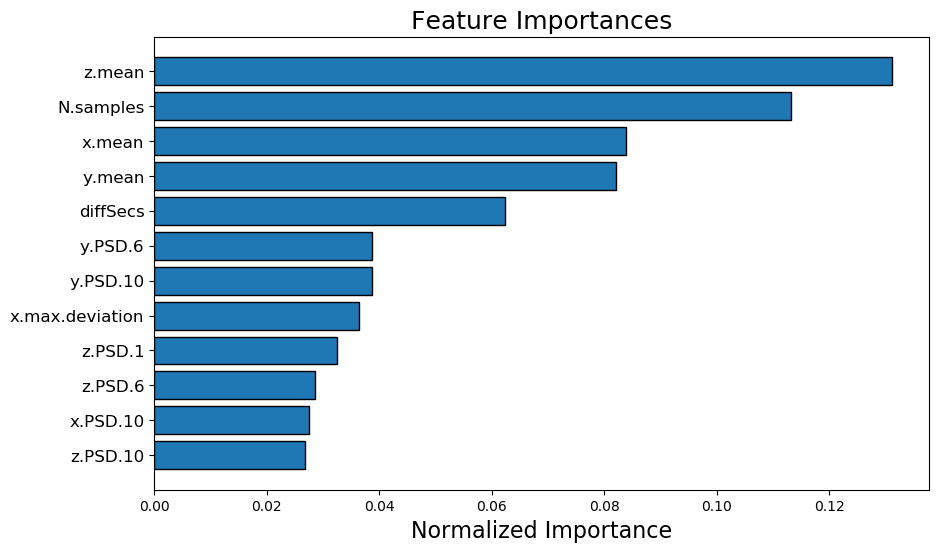

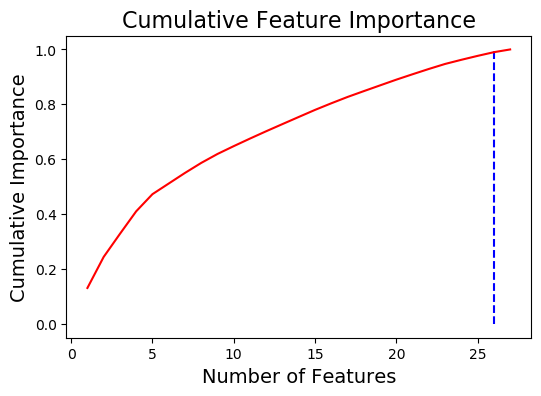

26 features required for 0.99 of cumulative importance


In [18]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

Overall, the package determined that about 5 features contribute 50% to predicting Parkinson's disease. Interestingly, the number of samples is the most important feature since I'm unsure how this is relevant to the Parkinson's status. What is good to see is that all the means features are considered important as well. Since Parkinson's patients suffer in a lack of mobility, there would be a noticable difference in the acceleration of patients walking around with and without Parkinson's.

# Classifying with Features Removed

In [19]:
important_features = fs.feature_importances
important_features

,feature,importance,normalized_importance,cumulative_importance
0,z.mean,241.3,0.131198,0.131198
1,N.samples,208.1,0.113147,0.244345
2,x.mean,154.4,0.083950,0.328295
3,y.mean,151.1,0.082155,0.410450
4,diffSecs,114.8,0.062418,0.472869
5,y.PSD.6,71.2,0.038712,0.511581
6,y.PSD.10,71.1,0.038658,0.550239
7,x.max.deviation,67.1,0.036483,0.586722
8,z.PSD.1,59.9,0.032569,0.619291
9,z.PSD.6,52.5,0.028545,0.647836


I decided to take the top five features of importance to train my model on the entire dataset. 

In [20]:
top5 = important_features['feature'].iloc[0:5]
top5 = list(top5)
top5

['z.mean', 'N.samples', 'x.mean', 'y.mean', 'diffSecs']

In [21]:
simplified_df = df2[top5]
simplified_df.head()

,z.mean,N.samples,x.mean,y.mean,diffSecs
12096044,-1.301763,35,6.750618,-6.608281,1.012
12215352,-8.807511,43,4.134529,-0.783620,1.009
2744272,-3.492504,79,8.633188,1.668304,1.000
12003709,-9.274495,34,3.059675,0.298526,1.016
12252697,-9.387861,44,1.756505,-1.827826,1.007


Then using these five features, I trained the various models again. I did not see a significant decrease in the score so I felt confident that these features were all I needed to classify Parkinson's status.

In [22]:
scaler = StandardScaler()
training_data = simplified_df
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df2['PK'], test_size=0.33, random_state=42)
clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=10000).fit(X_train, y_train)
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

0.7151799687010955 0.7015873015873015


In [23]:
scaler = StandardScaler()
training_data = simplified_df
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

from sklearn import linear_model
X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df2['PK'], test_size=0.33, random_state=42)
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, random_state=42).fit(X_train, y_train)
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

0.594679186228482 0.6063492063492063


In [24]:
scaler = StandardScaler()
training_data = simplified_df
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df2['PK'], test_size=0.33, random_state=42)
clf = LinearSVC(max_iter=10000, tol=1e-3, random_state=42).fit(X_train, y_train)
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

0.7151799687010955 0.7047619047619048


# Analyzing the Whole Dataset

Since the file is extremely huge, I imported the file into a lot of chunks.

In [25]:
df_chunk = pd.read_csv('accel.csv', index_col=0, chunksize=1000000)
df_chunk

With each chunk, I did some data cleaning and dropped any rows with infiinte or missing values. Since there was still a lot of rows after the data cleaning, I did not feel the need to implement data imputation.

In [26]:
chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    # perform data filtering 
    chunk = chunk.replace([np.inf, -np.inf], np.nan)
    chunk = chunk.dropna()
    chunk_filter = chunk[top5 + ['PK']]
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk_filter)
    
# concat the list into dataframe 
df_accel = pd.concat(chunk_list)

In [27]:
df_accel

,z.mean,N.samples,x.mean,y.mean,diffSecs,PK
1,9.652247,47,-0.067186,-0.316525,0.000000,0
2,9.784198,38,-0.089292,-0.321555,1.017763,0
3,9.842841,42,-0.051368,-0.316381,1.013795,0
4,9.787527,40,-0.063498,-0.305722,1.039792,0
5,9.835269,49,-0.069247,-0.284793,1.001845,0
...,...,...,...,...,...,...
12537120,-9.803708,30,0.675351,1.247079,1.022000,1
12537121,-9.759984,29,0.641828,1.245106,1.006000,1
12537122,-9.835753,31,0.635534,1.253670,1.001000,1
12537123,-9.804976,41,0.661112,1.245923,1.008000,1


Using groupby, I made sure that the number of rows for patients with Parkinson's or without Parkinson's follows a releative equal distribution. It is not as equal as I would have like, but it is not as lopsided either. Still, I felt confident enough to proceed forward with this data to train and test my model.

In [28]:
df_accel[['z.mean', 'PK']].groupby(['PK']).count()/12537124 *100

,z.mean
PK,
0,35.040724
1,64.959276


In [29]:
# To standarize the data
scaler = StandardScaler()
training_data = df_accel
scaler.fit(training_data)
training_data_scaled = scaler.transform(training_data)

Since this is with big data, I implemented a much small testing size of 0.1 instead of the traditional 0.3. However, this still nets me a large testing dataset to work with.

In [208]:
X_train, X_test, y_train, y_test = train_test_split(training_data_scaled, df_accel['PK'], test_size=0.1, random_state=42)

I've implemented a divide and conquer strategy here to split the training data into 10 chunks and train the model one chunk at a time.

In [212]:
num_of_minibatches = 10

X_train_minibatches = np.array_split(X_train, num_of_minibatches)
y_train_minibatches  = np.array_split(y_train, num_of_minibatches)

In [213]:
print(X_train_minibatches[0].shape, y_train_minibatches[0].shape)

(1128342, 6) (1128342,)


In [214]:
clf = linear_model.SGDClassifier(tol=1e-3, random_state=42)

# Train model
for i in np.arange(num_of_minibatches):
    clf.partial_fit(X_train_minibatches[i], y_train_minibatches[i], classes=np.unique(y_train))
    print('Minibatch ' + str(i) + ' ' + str(clf.score(X_train, y_train)))

Minibatch 0 0.9999185529978479
Minibatch 1 0.9999820089864669
Minibatch 2 0.9999887445383315
Minibatch 3 0.9999992909945405
Minibatch 4 0.9999997341229527
Minibatch 5 1.0
Minibatch 6 1.0
Minibatch 7 1.0
Minibatch 8 1.0
Minibatch 9 0.9999997341229527


In [215]:
clf.score(X_test, y_test)

1.0